#Political Statements Reliability Analysis
Naman Nagelia
Emily Cheng


# Introduction
# 
In today's fast-paced information age, distinguishing between true and false statements has become more challenging than ever. With the rise of social media and digital news platforms, information spreads at an unprecedented rate, making it difficult to verify credibility. Misinformation can shape public opinion, influence elections, and even impact policy decisions.

To address this challenge, we leverage Natural Language Processing (NLP) to analyze and classify statements based on their truthfulness. Using machine learning models, we aim to identify patterns in language, source credibility, and contextual indicators that differentiate true statements from false, half-true, mostly-true, and barely-true claims.

Our dataset consists of fact-checked statements made by public figures, politicians, and media sources, each labeled with a truthfulness category. By training our model on these labeled statements, we aim to develop an automated classification system that can predict the accuracy of new statements.

Throughout this project, we will explore:

Text preprocessing techniques (tokenization, stopword removal, stemming)

Feature extraction

Machine learning models (logistic regression, decision trees, neural networks)

Evaluation metrics (accuracy, precision, recall, F1-score)

While our model will not be perfect, it will serve as a foundation for improving automated fact-checking—a crucial tool in combating misinformation in the digital world.


# Data Curation



#Source: PolitiFact

Description: Contains political quotes with their truthfulness rating (e.g., True, Mostly True, Half True, False, Pants on Fire). Also includes contextual information about the speaker like who they are, the audience, the speaker's past statements and their political party.

We have 2 datasets from this website which we will use to help determine whether or not a political statement made by an individual with given qualities is likely to be reliable or false. The two datasets have different features and the purpose of this data curation section is to make htem consistent with each other


In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [87]:
statements = pd.read_csv('statements.tsv', sep='\t')
print(len(statements))
statements.head()

10239


,2635.json,false,Says the Annies List political group supports third-trimester abortions on demand.,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0.1,0.2,0.3,a mailer
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece


Since the dataset doesnt have headers, I set headers based on the descriptioin given on the politifact website. I then filled all na with 0's, and dropped columns that are irrelevant for our analysis

In [88]:
statements = pd.read_csv('statements.tsv', sep='\t', header=None)
statements.columns = ["id", "reliability", "statement", "subject", "speaker", "job_title", "state", "party", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_fire_counts", "audience"]
count_columns = ['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_fire_counts']
statements[count_columns] = statements[count_columns].fillna(0).astype(int)
statements.drop(columns = ["state", "job_title", "id"], inplace = True)
display(statements.head())

,reliability,statement,subject,speaker,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_fire_counts,audience
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,republican,0,1,0,0,0,a mailer
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,democrat,0,0,1,1,0,a floor speech.
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,democrat,70,71,160,163,9,Denver
3,false,Health care reform legislation is likely to ma...,health-care,blog-posting,none,7,19,3,5,44,a news release
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,democrat,15,9,20,19,2,an interview on CNN


The politifact dataset had Nan's instead of Zeros which we decided to turn into 0's, and then turn the previous count columns into Integers. We also split up the subjects into a list of the different subjects so its easier to categorize

In [89]:
statements['subject'].unique()
statements['subject'] = statements['subject'].apply(lambda x: x.split(',') if isinstance(x, str) else x)
statements['subject'] = statements['subject'].apply(lambda x: [item.strip() for item in x] if isinstance(x, list) else x)
statements.head()


,reliability,statement,subject,speaker,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_fire_counts,audience
0,false,Says the Annies List political group supports ...,[abortion],dwayne-bohac,republican,0,1,0,0,0,a mailer
1,half-true,When did the decline of coal start? It started...,"[energy, history, job-accomplishments]",scott-surovell,democrat,0,0,1,1,0,a floor speech.
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",[foreign-policy],barack-obama,democrat,70,71,160,163,9,Denver
3,false,Health care reform legislation is likely to ma...,[health-care],blog-posting,none,7,19,3,5,44,a news release
4,half-true,The economic turnaround started at the end of ...,"[economy, jobs]",charlie-crist,democrat,15,9,20,19,2,an interview on CNN


I now changed the format of speaker so we can use it later on in the second dataset

In [90]:
statements['speaker'] = statements['speaker'].astype(str).str.lower().str.replace('-', ' ')
statements.head()

,reliability,statement,subject,speaker,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_fire_counts,audience
0,false,Says the Annies List political group supports ...,[abortion],dwayne bohac,republican,0,1,0,0,0,a mailer
1,half-true,When did the decline of coal start? It started...,"[energy, history, job-accomplishments]",scott surovell,democrat,0,0,1,1,0,a floor speech.
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",[foreign-policy],barack obama,democrat,70,71,160,163,9,Denver
3,false,Health care reform legislation is likely to ma...,[health-care],blog posting,none,7,19,3,5,44,a news release
4,half-true,The economic turnaround started at the end of ...,"[economy, jobs]",charlie crist,democrat,15,9,20,19,2,an interview on CNN


In [91]:
true = ['half_true', 'mostly_true', 'true']
false = ['false', 'pants_fire', 'barely_true']
statements['verdict'] = statements['reliability'].apply(lambda x: 'true' if x in true else 'false')
display(statements.head())


,reliability,statement,subject,speaker,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_fire_counts,audience,verdict
0,false,Says the Annies List political group supports ...,[abortion],dwayne bohac,republican,0,1,0,0,0,a mailer,false
1,half-true,When did the decline of coal start? It started...,"[energy, history, job-accomplishments]",scott surovell,democrat,0,0,1,1,0,a floor speech.,false
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",[foreign-policy],barack obama,democrat,70,71,160,163,9,Denver,false
3,false,Health care reform legislation is likely to ma...,[health-care],blog posting,none,7,19,3,5,44,a news release,false
4,half-true,The economic turnaround started at the end of ...,"[economy, jobs]",charlie crist,democrat,15,9,20,19,2,an interview on CNN,false


Now we process the second politifact file, a json. We will read the json and turn it into a pandas dataframe, rename the columns to fit the conventions of the first dataframe, and drop the columns we dont need. The dataset is formatted differently and using the similar names from the first dataset and renaming features we can infer our missing values

In [92]:
statements2 = pd.read_json("politifact_factcheck_data.json", lines=True)
statements2.head()


,verdict,statement_originator,statement,statement_date,statement_source,factchecker,factcheck_date,factcheck_analysis_link
0,true,Barack Obama,John McCain opposed bankruptcy protections for...,6/11/2008,speech,Adriel Bettelheim,6/16/2008,https://www.politifact.com/factchecks/2008/jun...
1,false,Matt Gaetz,"""Bennie Thompson actively cheer-led riots in t...",6/7/2022,television,Yacob Reyes,6/13/2022,https://www.politifact.com/factchecks/2022/jun...
2,mostly-true,Kelly Ayotte,"Says Maggie Hassan was ""out of state on 30 day...",5/18/2016,news,Clay Wirestone,5/27/2016,https://www.politifact.com/factchecks/2016/may...
3,false,Bloggers,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",2/1/2021,blog,Madison Czopek,2/5/2021,https://www.politifact.com/factchecks/2021/feb...
4,half-true,Bobby Jindal,"""I'm the only (Republican) candidate that has ...",8/30/2015,television,Linda Qiu,8/30/2015,https://www.politifact.com/factchecks/2015/aug...


In [93]:
statements2['statement_originator'] = statements2['statement_originator'].astype(str).str.lower().str.replace('-', ' ')
statements2.rename(columns={'statement_originator': 'speaker', 'verdict': 'reliability', 'statement_source': 'audience'}, inplace=True)
statements2.drop(columns=["factchecker", "factcheck_date", "factcheck_analysis_link"], inplace=True)
statements2['verdict'] = statements2['reliability'].apply(lambda x: 'true' if x in true else 'false')
statements2.head()




,reliability,speaker,statement,statement_date,audience,verdict
0,true,barack obama,John McCain opposed bankruptcy protections for...,6/11/2008,speech,true
1,false,matt gaetz,"""Bennie Thompson actively cheer-led riots in t...",6/7/2022,television,false
2,mostly-true,kelly ayotte,"Says Maggie Hassan was ""out of state on 30 day...",5/18/2016,news,false
3,false,bloggers,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",2/1/2021,blog,false
4,half-true,bobby jindal,"""I'm the only (Republican) candidate that has ...",8/30/2015,television,false


Now as you see, were still missing many key elements from the first dataframe such as political party and their statement history. Using the names we can infer this, and we will determine the subject of the statement in the next step

In [94]:
speaker_to_party = statements[['speaker', 'party']].drop_duplicates().set_index('speaker')['party'].to_dict()
statements2['party'] = statements2['speaker'].map(speaker_to_party)

counts_columns = ['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_fire_counts']
statements['total_counts'] = statements[counts_columns].sum(axis=1)
max_count_rows = statements.loc[statements.groupby('speaker')['total_counts'].idxmax(), ['speaker'] + counts_columns]
statements2 = statements2.merge(max_count_rows, on='speaker', how='left')
statements2.fillna(0, inplace=True)
statements2.drop_duplicates(inplace=True)
statements2.head()


,reliability,speaker,statement,statement_date,audience,verdict,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_fire_counts
0,true,barack obama,John McCain opposed bankruptcy protections for...,6/11/2008,speech,true,democrat,70.0,71.0,160.0,163.0,9.0
1,false,matt gaetz,"""Bennie Thompson actively cheer-led riots in t...",6/7/2022,television,false,republican,0.0,1.0,1.0,1.0,0.0
2,mostly-true,kelly ayotte,"Says Maggie Hassan was ""out of state on 30 day...",5/18/2016,news,false,republican,2.0,1.0,1.0,4.0,0.0
3,false,bloggers,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",2/1/2021,blog,false,0,0.0,0.0,0.0,0.0,0.0
4,half-true,bobby jindal,"""I'm the only (Republican) candidate that has ...",8/30/2015,television,false,republican,0.0,1.0,4.0,4.0,0.0


Now the final column that is missing which is crucial is the subject of the statement. Using keywords, we can infer the topics. In order to classify each statement with relevant subjects, we employ a two-step approach that combines keyword-based inference and text similarity matching using Natural Language Processing (NLP).

To classify each statement with relevant subjects, we employ a two-step approach that combines keyword-based inference and semantic similarity matching using Sentence-BERT (SBERT).

1. Keyword-Based Subject Inference
To infer the subject of a statement, we use a predefined keyword-to-subject mapping. This mapping consists of key topics (e.g., economy, health-care, foreign-policy) and associated keywords commonly found in statements related to those topics.

By scanning each statement for the presence of these keywords, we can automatically infer up to three relevant subjects even if the statement does not explicitly mention the category.

Example Keyword-Based Classification:

A statement containing "inflation" or "GDP" is classified under "economy".

A statement mentioning "medicare" or "hospital" is linked to "health-care".

This method helps us efficiently label statements with topics even when there is no direct subject match in the dataset. However, keyword-based classification has limitations because it does not account for meaning and context.

2. Semantic Similarity-Based Subject Matching using SBERT
Since statements may cover complex or nuanced topics beyond simple keyword matching, we use SBERT embeddings and cosine similarity to match each statement to the most relevant subjects from our predefined topics.

Steps involved:
Convert all statements and subjects into SBERT embeddings – This captures the semantic meaning of both statements and policy topics. Bert considers context in the meaning of the word which is why we use it.

Compute cosine similarity between statement embeddings and subject embeddings – This measures how close a statement is to each policy category.

Identify the top three most similar subjects for each statement – The statement is assigned to the three closest subjects based on their vector representations.



In [95]:
all_topics = statements['subject'].explode().unique()
all_topics
#Looking at all the topics, i classified these manually
subject_map = {
    "abortion": ["abortion"],
    "energy": ["energy", "renewable", "oil", "gas", "coal", "gas-prices", "oil-spill"],
    "economy": ["economy", "inflation", "GDP", "market", "wealth", "deficit", "debt"],
    "jobs": ["jobs", "employment", "workforce", "hiring", "unions", "workers", "labor"],
    "health-care": ["health", "medicare", "insurance", "hospital", "medicaid", "public-health", "health-care"],
    "foreign-policy": ["war", "diplomacy", "treaty", "international", "iraq", "israel", "nuclear", "afghanistan", 'foreign-policy'],
    "elections": ["vote", "polls", "campaign", "ballot", "campaign-advertising", "redistricting", "elections"],
    "ethics": ["corruption", "ethics", "scandal", "fraud", "government-efficiency", "ethics"],
    "crime": ["crime", "criminal-justice", "law", "policing", "public-safety", "crime"],
    "climate-change": ["climate-change", "environment", "cap-and-trade", "climate-change"],
    "government-regulation": ["government-regulation", "market-regulation"],
    "technology": ["technology", "space", "science", "privacy"],
    "immigration": ["immigration", "border", "gays-and-lesbians"],
    "education": ["education", "schools", "teachers", "students"],
    "social-security": ["social-security", "pensions", "retirement"],
    "military": ["military", "veterans", "defense", "homeland-security"],
    "taxes": ["taxes", "financial-regulation", "bankruptcy", "stimulus"],
    "housing": ["housing", "real-estate"],
    "public-health": ["public-health", "disability", "drugs", "marijuana"],
    "transportation": ["transportation", "infrastructure"],
    "sports": ["sports", "baseball", "sports"],
    "religion": ["religion", "islam"],
    "food": ["food", "food-safety", "hunger", "nutrition"],
    "welfare": ["welfare", "poverty", "families"],
    "legal-issues": ["legal-issues", "supreme-court"],
    "public-service": ["public-service", "government-efficiency"],
}


In [96]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Load SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Get all subjects from the subject map
all_subjects = list(subject_map.keys())

# Encode the subjects
subject_embeddings = model.encode(all_subjects, convert_to_tensor=True)

# Encode the statements in statements2
statement_embeddings = model.encode(statements2["statement"].tolist(), convert_to_tensor=True)

# Compute cosine similarity between statements and subjects
similarity_matrix = cosine_similarity(statement_embeddings.cpu().numpy(), subject_embeddings.cpu().numpy())

# Get top 3 subjects for each statement
top_subjects = []
for i in range(len(statements2)):  # Iterate over rows (statements)
    similar_idx = similarity_matrix[i].argsort()[-3:][::-1]  # Top 3 subject indices for this statement
    subjects = [all_subjects[j] for j in similar_idx]  # Map indices back to subject names
    top_subjects.append(subjects)

statements2["subject"] = top_subjects
statements2.head()

,reliability,speaker,statement,statement_date,audience,verdict,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_fire_counts,subject
0,true,barack obama,John McCain opposed bankruptcy protections for...,6/11/2008,speech,true,democrat,70.0,71.0,160.0,163.0,9.0,"[welfare, legal-issues, health-care]"
1,false,matt gaetz,"""Bennie Thompson actively cheer-led riots in t...",6/7/2022,television,false,republican,0.0,1.0,1.0,1.0,0.0,"[economy, welfare, immigration]"
2,mostly-true,kelly ayotte,"Says Maggie Hassan was ""out of state on 30 day...",5/18/2016,news,false,republican,2.0,1.0,1.0,4.0,0.0,"[legal-issues, immigration, social-security]"
3,false,bloggers,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",2/1/2021,blog,false,0,0.0,0.0,0.0,0.0,0.0,"[public-health, crime, legal-issues]"
4,half-true,bobby jindal,"""I'm the only (Republican) candidate that has ...",8/30/2015,television,false,republican,0.0,1.0,4.0,4.0,0.0,"[elections, government-regulation, foreign-pol..."


# Exploratory Data Analysis

In this section of the data science life cycle, we are going to graph the data in order to gain a better understanding of the data between our datasets. Lets first concat both of the DF into one main DF

In [97]:
print(statements.columns)

statements2.drop(columns=['statement_date'], inplace=True)
print(statements2.columns)

statements_main = pd.concat([statements, statements2], ignore_index=True)


Index(['reliability', 'statement', 'subject', 'speaker', 'party',
       'barely_true_counts', 'false_counts', 'half_true_counts',
       'mostly_true_counts', 'pants_fire_counts', 'audience', 'verdict',
       'total_counts'],
      dtype='object')
Index(['reliability', 'speaker', 'statement', 'audience', 'verdict', 'party',
       'barely_true_counts', 'false_counts', 'half_true_counts',
       'mostly_true_counts', 'pants_fire_counts', 'subject'],
      dtype='object')


In [98]:
print(statements.shape)
print(statements2.shape)
statements_main.shape
statements_main.head()

(10240, 13)
(21150, 12)


,reliability,statement,subject,speaker,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_fire_counts,audience,verdict,total_counts
0,false,Says the Annies List political group supports ...,[abortion],dwayne bohac,republican,0.0,1.0,0.0,0.0,0.0,a mailer,false,1.0
1,half-true,When did the decline of coal start? It started...,"[energy, history, job-accomplishments]",scott surovell,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,false,2.0
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",[foreign-policy],barack obama,democrat,70.0,71.0,160.0,163.0,9.0,Denver,false,473.0
3,false,Health care reform legislation is likely to ma...,[health-care],blog posting,none,7.0,19.0,3.0,5.0,44.0,a news release,false,78.0
4,half-true,The economic turnaround started at the end of ...,"[economy, jobs]",charlie crist,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,false,65.0


In [99]:
# Democrat, republican, independent (moderates, )

statements_main.party.value_counts()
statements_main['party'] = statements_main['party'].replace({
    "organization": 'media', 
    'newsmaker': 'media', 
    'journalist': 'media', 
    'columnist': 'media', 
    'talk-show-host': 'media',
    'none': 'independent', 
    'Moderate': 'independent', 
    0: 'independent', 
    "moderate": "independent"
})

# Replace specified parties with 'other'
statements_main['party'] = statements_main['party'].replace({
    'libertarian': 'other',
    'activist': 'other',
    'state-official': 'other',
    'labor-leader': 'other',
    'tea-party-member': 'other',
    'business-leader': 'other',
    'green': 'other',
    'education-official': 'other',
    'liberal-party-canada': 'other',
    'government-body': 'other',
    'democratic-farmer-labor': 'other',
    'ocean-state-tea-party-action': 'other',
    'constitution-party': 'other'
})

statements_main['party'].value_counts()


party
independent    11269
republican     11193
democrat        7877
media            734
other            315
Name: count, dtype: int64

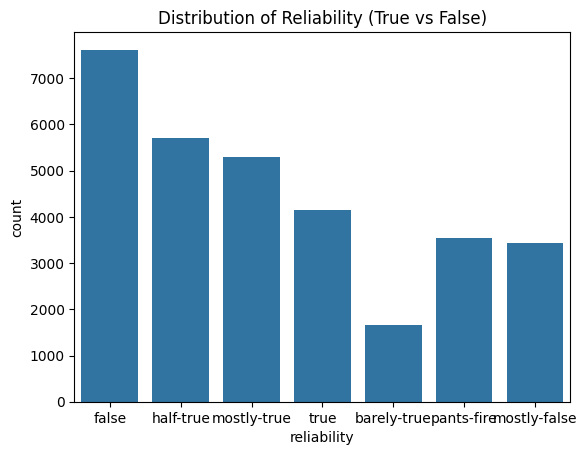

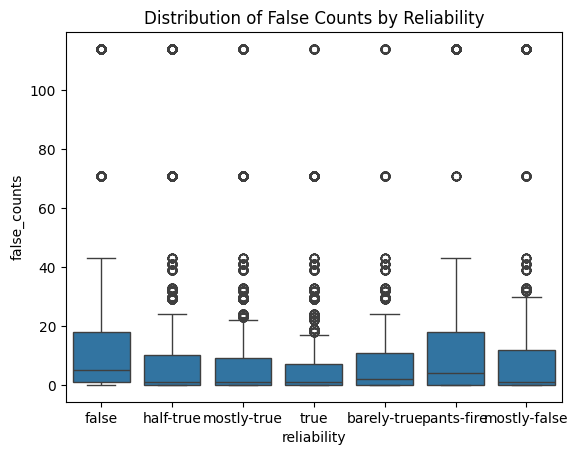

,reliability,statement,subject,speaker,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_fire_counts,audience,verdict,total_counts
0,false,Says the Annies List political group supports ...,[abortion],dwayne bohac,republican,0.0,1.0,0.0,0.0,0.0,a mailer,false,1.0
1,half-true,When did the decline of coal start? It started...,"[energy, history, job-accomplishments]",scott surovell,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,false,2.0
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",[foreign-policy],barack obama,democrat,70.0,71.0,160.0,163.0,9.0,Denver,false,473.0
3,false,Health care reform legislation is likely to ma...,[health-care],blog posting,independent,7.0,19.0,3.0,5.0,44.0,a news release,false,78.0
4,half-true,The economic turnaround started at the end of ...,"[economy, jobs]",charlie crist,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,false,65.0


Chi-squared statistic (Job Title): 840.8600857987697
P-value (Job Title): 1.0821260073373268e-180
Degrees of Freedom (Job Title): 4
Expected Frequencies (Job Title):
[[5965.72078501 1911.27921499]
 [8534.68421053 2734.31578947]
 [ 555.90187333  178.09812667]
 [ 238.56824264   76.43175736]
 [8477.12488849 2715.87511151]]


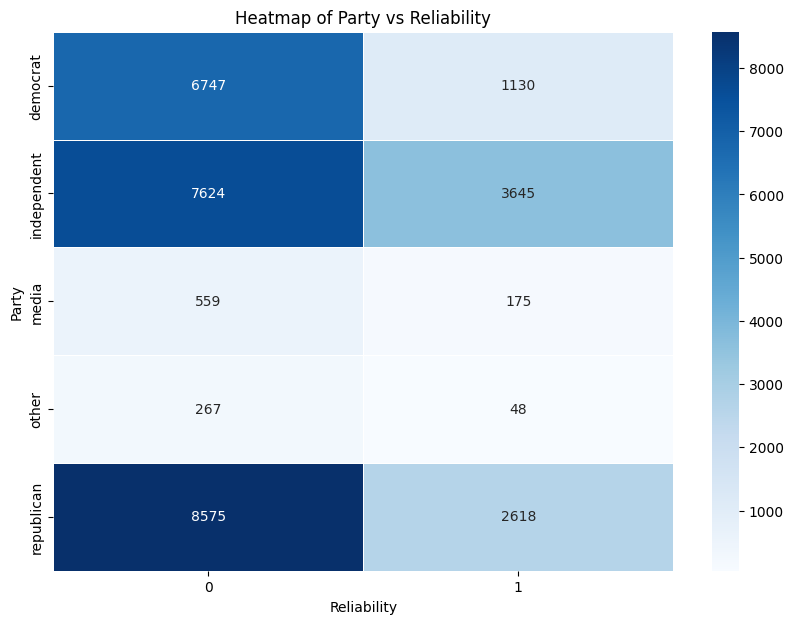

In [100]:
import seaborn as sns
sns.countplot(data=statements_main, x='reliability')
plt.title('Distribution of Reliability (True vs False)')
plt.show()

sns.boxplot(data=statements_main, x='reliability', y='false_counts')
plt.title('Distribution of False Counts by Reliability')
plt.show()










from scipy.stats import chi2_contingency

display(statements_main.head())
true = ['half_true', 'mostly_true', 'true']
false = ['false', 'pants_fire', 'barely_true']

statements_main['Fake'] = statements_main['reliability'].apply(lambda x: 1 if x == 'false' else 0)
contingency_table = pd.crosstab(statements_main['party'], statements_main['Fake'])
chi2_job_title, p_value_job_title, dof_job_title, expected_job_title = chi2_contingency(contingency_table)
# print(contingency_job_title)
print(f"Chi-squared statistic (Job Title): {chi2_job_title}")
print(f"P-value (Job Title): {p_value_job_title}")
print(f"Degrees of Freedom (Job Title): {dof_job_title}")
print(f"Expected Frequencies (Job Title):\n{expected_job_title}")
plt.figure(figsize=(10, 7))
heatmap = sns.heatmap(contingency_table, annot=True, fmt="d", cmap="Blues", cbar=True, linewidths=0.5)
plt.title('Heatmap of Party vs Reliability')
plt.xlabel('Reliability')
plt.ylabel('Party')
plt.show()

For our second exploration, we will see if there is any correalation between a politicians past statements as evidenced by their past truthfullness counts, and then their statements reliability to see if there is correalated. I will use a heatmap with a pearson coefficient to show this alongise a correalation matrix.

,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_fire_counts
barely_true_counts,1.000000,0.928438,0.888552,0.842780,0.525066
false_counts,0.928438,1.000000,0.717168,0.650513,0.705664
half_true_counts,0.888552,0.717168,1.000000,0.986296,0.263526
mostly_true_counts,0.842780,0.650513,0.986296,1.000000,0.184230
pants_fire_counts,0.525066,0.705664,0.263526,0.184230,1.000000


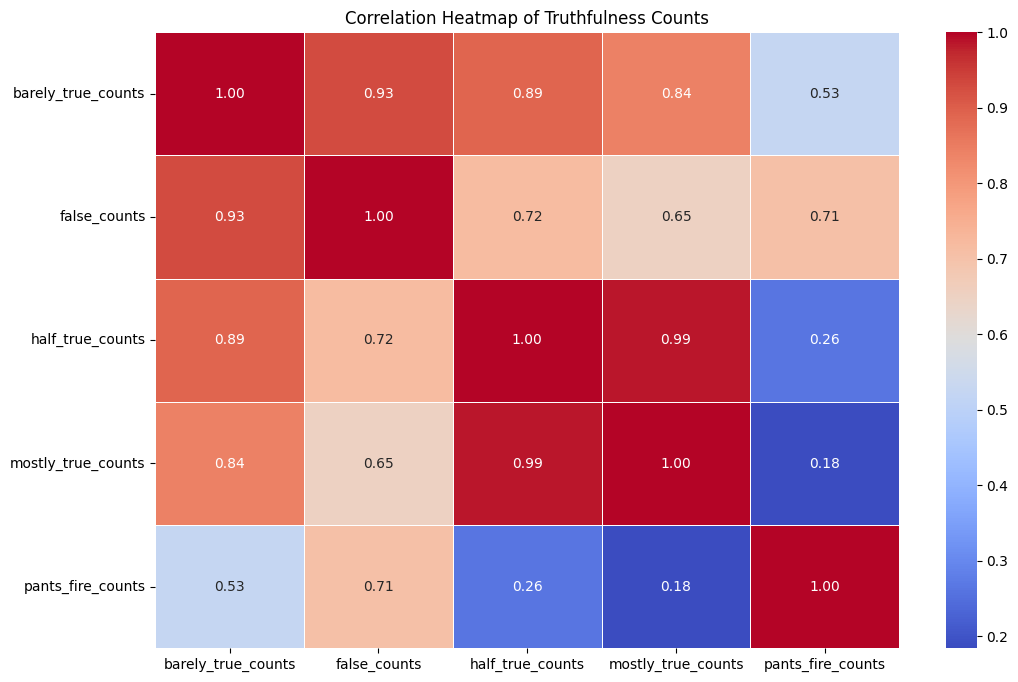

In [101]:
truthfulness_columns = ['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_fire_counts']
correlation_matrix = statements_main[truthfulness_columns].corr(method='pearson')
display(correlation_matrix)



plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.title("Correlation Heatmap of Truthfulness Counts")
plt.show()




In [104]:
import pandas as pd
politician_verdicts = statements_main.groupby(["speaker", "verdict"]).size().unstack(fill_value=0)
truthfulness_agg = statements_main.groupby("speaker")[["barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_fire_counts"]].mean().astype(int)
politician_verdicts = politician_verdicts.merge(truthfulness_agg, left_index=True, right_index=True, how="left")

expected_categories = ["true", "false", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_fire_counts"]
for category in expected_categories:
    if category not in politician_verdicts.columns:
        politician_verdicts[category] = 0

politician_verdicts.head()

,false,true,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_fire_counts
speaker,,,,,,,
"""watch the water""",1,0,0,0,0,0,0
10 gop louisiana lawmakers,1,0,0,0,0,0,0
13th district gop slate,1,0,0,0,0,0,0
18 percent american public,1,1,0,0,0,0,1
18% of the american public,1,0,0,0,0,0,0
